# Text Extraction

## Introduction

The following notebook details Merve Tekgürler's approach to text extraction from the Parti Pris corpus from Summer 2025.

<figure>
    <img src="../img/parti_pris_cover.png"
         alt="Cover of Parti Pris's October 1963 issue">
    <figcaption>Cover of <a href="https://collections.banq.qc.ca/ark:/52327/2314782" target="_blank">Parti Pris' inaugural issue</a> from October 1963.</figcaption>
</figure>

In 2023-2024, Chloé Brault, Clare Chua, and Em Ho compiled the Parti Pris corpus and extracted texts from the same PDFs using ABBYY FineReader. More details about their work can be found [here](https://msuglobaldh.org/abstracts/#brault).

Tekgürler and Brault revisited the project in Summer 2025. This notebook describes how we used Gemini 2.5 API to extract texts from the Parti Pris corpus. It shared the prompting code and offers some insights into the decisions that went into the designing of the prompts as well as safeguards to verify the quality of the OCR output. We 

## Corpus

The complete Parti Pris PDF corpus is approximately 3.48GB in size and includes all 42 issues from the magazine’s entire print run, digitized by the Bibliothèque et Archives Nationales du Québec (BAnQ).

<figure>
    <img src="../img/banq.png"
         alt="Screenshot showing the search page for Parti Pris on the BAnQ website">
    <figcaption>Searching for Parti Pris on the BAnQ website. You can find all the issues of Parti Pris and download the PDFs by following <a href="https://numerique.banq.qc.ca/rechercheExterne/encoded/Kg==/false/D/asc/W3sibm9tIjoiY29ycHVzIiwidmFsZXVyIjoiUGF0cmltb2luZSUyMHF1w6liw6ljb2lzIn0seyJub20iOiJ0eXBlX2RvY19mIiwidmFsZXVyIjoiUmV2dWVzJTIwZXQlMjBqb3VybmF1eCJ9LHsibm9tIjoibnVtZXJvX25vdGljZSIsInZhbGV1ciI6IjAwMDAxNjMxMjIifV0=/Toutes%20les%20ressources/true/false/" target="_blank">this search link</a>. </figcaption>
</figure>

There are three example PDFs in the data folder of this repository (../data/full_pdfs and ../data/split_pdfs), for testing the code in this notebook.

## Prompting Approach

The previous iteration of this project experimented with OCR'ing entire issues of Parti Pris and then spliting it into small chunks of text for further analysis. This allowed us, for example, to experiment with Named Entity Recognition algorithms to identify places mentioned in this corpus or run word frequency-based analyses to discover trends across the whole corpus. It has however proven to be rather difficult to split the OCR'ed issues into individual articles.

In this new iteration of the project, we revisit our approach to OCR. We use the Gemini 2.5 API to extract text and return a JSON object containing each article as a separate entry.

### Gemini API Key

To prompt Gemini for text extraction, you need to obtain an API key. [This Authentication notebook](https://github.com/google-gemini/cookbook/blob/db5e894d85ccef13cb95d65353407f4ffbcd297c/quickstarts/Authentication.ipynb) shows you how to obtain an API key. If you are new to Gemini or generally accessing LLMs through API calls, [this Getting Started notabook](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb) is a great place to start experimenting.

Once you have an API key, create a `.env` file in the root of your repository and add it to `.gitignore`. After pushing the changes to GitHub, spen your `.env` file and type `GEMINI_API_KEY="YOUR_API_KEY"`, where "YOUR_API_KEY" corresponds to the actual key.

In [57]:
# Let's load our API key from the environment
# we will use the python-dotenv package to load the .env file 
# https://pypi.org/project/python-dotenv/

import os
from dotenv import load_dotenv

load_dotenv() # By default load_dotenv will look for the .env file in the current working directory

api_key = os.getenv("GEMINI_API_KEY")

if api_key:
    print("API key loaded successfully.")

API key loaded successfully.


### Configure Gemini API

In [ ]:
%pip install -U -q 'google-genai>=1.0.0'
%pip install pypdf
%pip install pillow

In [61]:
from google import genai
from google.genai import types

client = genai.Client(api_key=api_key)

In [62]:
# Initialize Gemini 2.5 Flash
MODEL_ID = 'gemini-2.5-flash'

In [66]:
# small test to make sure that the model is working

from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the largest planet in our solar system?"
)

Markdown(response.text)

The largest planet in our solar system is **Jupiter**.

### Designing the Prompt for Text Extraction

The goal of our project is to get high quality and accurate OCR output for each issue of Parti Pris, split by article. We also have some constraints: 

- We are working with PDFs, so we need to upload files with our prompt.
- We want structured output, so JSON generation is our best option.
- We want to control the generation, so we need to understand how the criteria for text extraction that we outline in our prompt impacts the output.
- We need to figure out how the thinking aspect of Gemini 2.5 changes impacts prompting

For further refences, please take a look at Gemini code examples and documentation.
- Document Understanding and Processing: [documentation](https://ai.google.dev/gemini-api/docs/document-processing), [code](https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/document-processing/document_processing.ipynb#scrollTo=Nqwi-5ufWp_B)
- Structured Output and JSON: [documentation](https://ai.google.dev/gemini-api/docs/structured-output), [code](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb#scrollTo=JiIxKaLl4R0f)
- Thinking: [documentation](https://ai.google.dev/gemini-api/docs/thinking)

In [67]:
# 1. Let's upload a PDF file and ask the model to summarize it
# This way we can test the model's ability to handle file uploads

import pathlib

pdf_path = pathlib.Path('../data/full_pdfs/163122_1-1963-10.pdf')

file_upload = client.files.upload(file=pdf_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Can you summarize this file as a bulleted list?",
    ]
)

Markdown(response.text)

This document is the first issue of *Parti Pris*, a political and literary review published in Montreal in October 1963.

Here's a summary of its key contents and philosophy:

*   **Overall Mission & Stance:**
    *   *Parti Pris* aims to be a "political and literary review" that "takes a stance" (*prendre parti*) rather than adopting a detached "objectivity."
    *   It seeks to "demystify" and "create a truth" that transforms Quebec society, viewing analysis and reflection as integral parts of action.
    *   The ultimate goal is to achieve a "free, secular, and socialist State" through a "total revolution."

*   **Analysis of Quebec's Situation ("Notre Perspective"):**
    *   **Alienation:** Quebec is described as a "colonized and exploited" society, suffering from alienation at political, economic, and cultural levels due to external domination (Canadian/American) and internal structures.
    *   **Critique of Previous Generation:** The magazine criticizes older intellectuals (e.g., *Cité Libre*) for their "abstract dialogue" and "objectivity," which failed to address the root causes of alienation and avoided radical change.
    *   **Youth as Revolutionary Force:** The current generation is presented as having moved beyond individual "revolt" (like the "Refus Global" movement) to a collective "revolutionary attitude," understanding societal alienation as a colonial problem.
    *   **The FLQ (Front de libération du Québec):** The arrests of FLQ members are presented as a manifestation of this new, impatient youth, whose violence is seen as a "therapeutic effect" necessary to shake the long-stagnant society and reveal its inherent violence.

*   **Historical & Sociological Context ("Du Duplessisme au F.L.Q."):**
    *   **Legacy of Conquest:** The 1760 conquest led to French Canadians being restricted to religious and cultural spheres, while political and economic control remained with others.
    *   **"Feudal Spirit" & "Agriculturism":** The clerical and traditional elite perpetuated a "feudal spirit" and an "agriculturist" ideology, which, by devaluing industrialization and finance, effectively left the economic field open to foreign capitalists.
    *   **Industrialization & Mass Culture:** Despite the elite's efforts, industrialization and urbanization brought American mass culture, leading to the "assimilation" of Quebecers and exacerbating their economic inferiority and unemployment.
    *   **Political Evolution (1960-1963):** The Liberal victory in 1960 and the nationalization of electricity are seen as positive steps, but the fundamental struggle against Canadian Confederation and foreign economic control continues.

*   **Vision for "Total Revolution" ("Vers une révolution totale"):**
    *   **Comprehensive Change:** A "total revolution" is defined as a radical transformation of the entire life of the people (economy, social structures, politics, culture), going beyond mere political shifts.
    *   **Two Fundamental Contradictions:**
        1.  Canado-American imperialism.
        2.  Private appropriation of national wealth and exploitation of wage labor.
    *   **Solutions:**
        *   **Political Independence:** Essential for Quebec (ideally a "French Republic in America") to gain control over its destiny.
        *   **Economic Socialism:** Nationalization of all significant foreign-controlled enterprises is deemed necessary for genuine economic liberation, a step impossible under capitalism or within the existing Confederation.
        *   **New Democracy:** Emphasizes "people's power" through the conscious participation of the working masses and a "National Unity Government" (Front National et Populaire), moving beyond traditional parliamentary democracy.
    *   **Interconnectedness:** Socialism, popular democracy, and independence are presented as an inseparable trinity.

*   **Cultural & Critical Sections ("Poèmes" & "Chroniques"):**
    *   **Poetry:** Features poems by Paul Chamberland and André Brochu (and André Major) that reflect themes of identity, land, anger, hope, and the struggle for liberation.
    *   **Critique of Information:** The magazine's "Chroniques" section critiques mainstream media for its "mystification" and biased portrayal of the FLQ and separatist movements.
    *   **RIN & FLQ:** Discusses the RIN's (Rassemblement pour l'indépendance nationale) evolution and its eventual acceptance of the FLQ's violent actions as a necessary catalyst for the revolution.
    *   **Cultural Criticism:** Argues that cultural production is directly linked to political and economic realities, and therefore cultural criticism must be revolutionary.
    *   **Abrasive Tone:** The "Vulgarités" section explicitly states its intention to be "vulgar and vengeful" to express animosities and challenges, showcasing the magazine's confrontational style.

The issue lays out a foundational ideology for Quebec's independence movement, intertwining political, economic, and cultural liberation, and positioning *Parti Pris* as a key intellectual driver of this "total revolution."

In [ ]:
print(response)

```python
sdk_http_response=HttpResponse(
  headers=<dict len=11>
) candidates=[Candidate(
  content=Content(
    parts=[
      Part(
        text='[not shown here due to space]'
      ),
    ],
    role='model'
  ),
  finish_reason=<FinishReason.STOP: 'STOP'>,
  index=0
)] create_time=None response_id=None model_version='gemini-2.5-flash' prompt_feedback=None usage_metadata=GenerateContentResponseUsageMetadata(
  candidates_token_count=933,
  prompt_token_count=17040,
  prompt_tokens_details=[
    ModalityTokenCount(
      modality=<MediaModality.TEXT: 'TEXT'>,
      token_count=12
    ),
    ModalityTokenCount(
      modality=<MediaModality.DOCUMENT: 'DOCUMENT'>,
      token_count=17028
    ),
  ],
  thoughts_token_count=2753,
  total_token_count=20726
) automatic_function_calling_history=[] parsed=None
```

Based on the information contained in the whole prompt, we can see that the `prompt_token_count` has two modalities: text and document. Text is the part of the prompt that we have written and document is our PDF.

`thoughts_token_count` refers to the thought token that the model used in an internal thinking process.

`candidates_token_count` refers to the output tokens

In [68]:
# Let's print the usage metadata
print("Prompt tokens:",response.usage_metadata.prompt_token_count)
print("Thoughts tokens:",response.usage_metadata.thoughts_token_count)
print("Output tokens:",response.usage_metadata.candidates_token_count)
print("Total tokens:",response.usage_metadata.total_token_count)

Prompt tokens: 17040
Thoughts tokens: 2661
Output tokens: 1092
Total tokens: 20793


- Prompt tokens: 17040
- Thoughts tokens: 2661
- Output tokens: 1092
- Total tokens: 20793

This shows that the model used more than 2.5 times as many thinking tokens as output tokens.

In [ ]:
# 2. Let's upload the same PDF file and ask the model to extract text from it
# At the same time, let's also set a specific thinking budget for the model

pdf_path = pathlib.Path('../data/full_pdfs/163122_1-1963-10.pdf')

file_upload = client.files.upload(file=pdf_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Transcribe the entire PDF. Do not change a word. Make sure to mark the beginnings of each section clearly.",
    ],
    config=types.GenerateContentConfig(
        thinking_config=types.ThinkingConfig(thinking_budget=1024)
        # Turn off thinking:
        # thinking_config=types.ThinkingConfig(thinking_budget=0)
        # Turn on dynamic thinking:
        # thinking_config=types.ThinkingConfig(thinking_budget=-1)
    ),
)

Markdown(response.text)

In [ ]:
# save response to a file
output_path = pathlib.Path('../data/instructional/1963-10_test1.txt')
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, 'w') as f:
    f.write(response.text)

In [ ]:
# You can see the response by loading it from the saved file
with open('../data/instructional/1963-10_test1.txt', 'r') as f:
    response_text = f.read()
print(response_text)

In [71]:
# Let's see the usage metadata
print("Prompt tokens:",response.usage_metadata.prompt_token_count)
print("Thoughts tokens:",response.usage_metadata.thoughts_token_count)
print("Output tokens:",response.usage_metadata.candidates_token_count)
print("Total tokens:",response.usage_metadata.total_token_count)

Prompt tokens: 17052
Thoughts tokens: 1273
Output tokens: 40650
Total tokens: 58975


Hmm, our output is not that useful. It looks more like the output of an OCR software, which does not produce the same kind of structure that we need. (If you cannot run this test, please instead take a look at the text file at ../data/1963-10_test1.text)

We seem to be on the right track though!

There are two ways to get a model to produce JSON files.

1. Describing a JSON structure in the prompt
2. Creating a JSON schema

This is what a prompt for a JSON structure looks like

```python
prompt = """
Transcribe the entire PDF as accurately as possible, preserving the original words.

Fix only hyphenated words that are split across lines (e.g., “hyphen-\nation” → “hyphenation”).
Preserve paragraph breaks, but remove all line breaks within paragraphs.

This PDF contains multiple articles. For each article, extract and return the following in a JSON format:

    author: the author's name

    title: the article title

    pages: the page range (e.g., "12–15")

    text: the full transcribed text

Return one JSON object with all the articles.
"""
```

This works too, but the JSON schema method turned out to be more reliable, which is what we did for extracting texts below.

In [ ]:
# 3. JSON time! Let's bring in some structure to the response

import json
import typing_extensions as typing

# Define your article schema
class Article(typing.TypedDict):
    author: str
    title: str
    pages: str
    text: str

pdf_path = pathlib.Path('../data/full_pdfs/163122_1-1963-10.pdf')
json_filename = '../data/instructional/1963-10_test2.json'

file_upload = client.files.upload(file=pdf_path)

prompt = """
Transcribe the entire PDF as accurately as possible, preserving the original words.

Fix only hyphenated words that are split across lines (e.g., “entrepri- se” → “entreprise”).
Preserve paragraph breaks, but not line breaks.
This PDF contains multiple articles.
Return ONLY a JSON array of articles, with no extra text or explanation.
"""

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[file_upload, prompt],
    config={
        'response_mime_type': 'application/json',
        'response_schema': list[Article],
        'thinking_config': types.ThinkingConfig(thinking_budget=2000)
    },
)

# Parse the JSON string to a Python object
data = json.loads(response.text)

# Save the Python object as JSON
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("Prompt tokens:",response.usage_metadata.prompt_token_count)
print("Thoughts tokens:",response.usage_metadata.thoughts_token_count)
print("Output tokens:",response.usage_metadata.candidates_token_count)
print("Total tokens:",response.usage_metadata.total_token_count)

Prompt tokens: 17107
Thoughts tokens: 1547
Output tokens: 32215
Total tokens: 50869


In [ ]:
Markdown(response.text)

Much better! We can clearly see that the model followed the schema. Each article in this issue looks like this:

```python
{
    "author": "Comité de rédaction",
    "title": "présentation",
    "pages": "4-6",
    "text": "Prendre parti, essentiellement, ......."
}
```

Again if you cannot run this code, you can see the output by opening the JSON file (../data/1963-10_test2.json)

In [ ]:
# Let's loop through the PDF corpus and extract the text from each PDF file
# We won't actually run this code, but you can use it as a template for your own corpus

import pathlib
import json
import typing_extensions as typing
import csv
from IPython.display import Markdown
import time

# Define your article schema
class Article(typing.TypedDict):
    author: str
    title: str
    page_range: str
    text: str

# Paths
pdf_folder = pathlib.Path('your_path_here/pdfs')
output_folder = pathlib.Path('your_path_here/gemini_transcriptions')
output_folder.mkdir(exist_ok=True)
csv_path = output_folder / 'transcription_usage.csv'

# Prepare CSV
csv_fields = ['pdf_filename', 'json_filename', 'prompt_tokens', 'thoughts_tokens', 'output_tokens', 'total_tokens', 'note']
if not csv_path.exists():
    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
        writer.writeheader()

# Prompt
prompt = """
Transcribe the entire PDF as accurately as possible, preserving the original words.

Fix only hyphenated words that are split across lines (e.g., “entrepri- se” → “entreprise”).
Preserve paragraph breaks, but not line breaks.
This PDF contains multiple articles.
Return ONLY a JSON array of articles, with no extra text or explanation.
"""

# Loop over PDFs
for pdf_path in pdf_folder.glob('*.pdf'):
    print(pdf_path)
    filename = pdf_path.stem
    json_filename = filename + '.json'
    json_path = output_folder / json_filename

    # Check file size (50MB = 50 * 1024 * 1024 bytes)
    if pdf_path.stat().st_size > 50 * 1024 * 1024:
        # Log skipped file
        info = {
            'pdf_filename': pdf_path.name,
            'json_filename': '',
            'prompt_tokens': '',
            'thoughts_tokens': '',
            'output_tokens': '',
            'total_tokens': '',
            'note': 'SKIPPED: file too large'
        }
        with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
            writer.writerow(info)
        print(f"Skipped (too large): {pdf_path.name}")
        continue

    file_upload = client.files.upload(file=pdf_path)


    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[file_upload, prompt],
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[Article],
            'thinking_config': types.ThinkingConfig(thinking_budget=2000)
        },
    )

    # Parse and save JSON
    data = json.loads(response.text)
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    # Gather usage info
    info = {
        'pdf_filename': pdf_path.name,
        'json_filename': json_filename,
        'prompt_tokens': response.usage_metadata.prompt_token_count,
        'thoughts_tokens': response.usage_metadata.thoughts_token_count,
        'output_tokens': response.usage_metadata.candidates_token_count,
        'total_tokens': response.usage_metadata.total_token_count
    }

    # Save to CSV
    with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
        writer.writerow(info)

    # Print info
    print(f"Processed: {json_filename}")
    print(f"Prompt tokens: {info['prompt_tokens']}")
    print(f"Thoughts tokens: {info['thoughts_tokens']}")
    print(f"Output tokens: {info['output_tokens']}")
    print(f"Total tokens: {info['total_tokens']}\n")

    # Wait before next request
    time.sleep(30)

While we won't be able to run the code above, we want to highlight a few things from it

First of all, don't forget to add `time.sleep()` after each API call. We wait 30 seconds between calls which ensures that we won't hit the API limits.

Second, we are creating a CSV and keeping track of three things:
1. Some PDFs are over 50MB, which means that they cannot be processed in API calls. We keep track of this to return to these PDFs later
2. We are saving the usage data, which we will use later for quality control
3. Filenames! We are saving the name of the PDF and the name of the JSON file so that we can always find the correct files through this CSV

Third, we tweaked our prompt. Since the JSON schema is uploaded with the prompt `'response_mime_type': 'application/json'` and `'response_schema': list[Article]`, we do describe the structure in the prompt. Instead we use that space for clarifying some details regarding text extraction.

Four, we save each file right after it is created. This way if something goes wrong, we don't loose hours of work.

## Discussion

### Advantages

There are many advantanges to this approach. We automatically obtain texts split at article level associated with the author of that article as opposed to just with Parti Pris. Parti Pris has relatively standard layout and very few if any images or advertisement. The language is standard mid-century French. Most issues are about 60 pages long, which fits the context window of the model. The scans are in a high resolution. The model can be prompted to perform specific transformations such as making the paragraph breaks but not line breaks and joining hyphenated words back into full words. All this makes text extraction easier.

### Challenges

At the same time there are some challenges inherent in prompting a Large Language Model (LLM) for OCR. These includes issues related to the size of the PDFs and difficulties with verifying the quality and the completeness the outputs. 

**PDF Size**

the PDFs uploaded to the Gemini API cannot be larger than [50MB](https://github.com/googleapis/python-genai/issues/308). We had a total of 42 PDFs in this corpus and 18 of them were over 50MB. Some were only marginally larger, others were combined issues, reaching over 120 pages and 100MB. We could not split the PDFs automatically by size since our goal was to capture each article separately. A size or page number based approach could split up an article in the middle. This meant that we had to either reduce the size of the PDFs and risk reducing the quality of the resolution or split them manually. 

We had a two-part approach. First we transcribed all the PDFs, skipping the ones that were too large and making a note about that in the process. Afterwards we manually split the 18 large PDFs in Adobe Acrobat Pro, creating 42 new PDFs. We retained the filenames, adding '-A', '-B', etc to the end of the filenames. Then we ran a second pass of Gemini 2.5 transcription with the split PDFs.

<figure>
    <img src="../img/large_pdfs.png"
         alt="Screenshot showing the transcription token usage for API calls">
    <figcaption>Transcription token usage after the first pass</figcaption>
</figure>

<figure>
    <img src="../img/second_pass_pdfs.png"
         alt="Screenshot showing the transcription token usage for API calls">
    <figcaption>Transcription token usage after the second pass</figcaption>
</figure>

**Quality and Completeness of the Output**

*Before the API calls*

Best method to check the quality of the output is to read the extracted texts and compare it to what you see on the PDF. We manually checked several examples before proceeding with the API calls. We tweaked our prompting based on these initial experiments. For example, we realized that the model marks line breaks with '\n' which is not necessary for our research and prompted the model to not do that. Please note that marking the end of a line could be very useful if  for example you are working with a manuscript and want to publish a digital edition. You do need to mark the line breaks in that case.

We also realized that the texts contained a lot of hyphenated words at the end of a line. Hyphenation is not common in English but in French, the word at the end of a line is split at the end of the last syllable that fits the line, an hyphen is added to signal this split and the rest of the word continues in the line below. The model tended to keep the hyphens resulting in words like 'enter- prise' instead of merging the word to 'enterprise'. It is not easy to get rid of hyphenation in post-OCR correction because French does make use of the hyphen regularly, for example in the contruction of a question like 'c'est' becomes 'est-ce'. This means that removing - as if it is just puncuation is not ideal. 

Picking up on the smaller, often language and corpus specific details helps design a more effective prompt.

<figure>
    <img src="../img/hyphenation.png"
         alt="Screenshot showing different uses of hyphen">
    <figcaption>Different uses of hyphen marked in red, when it is used for splitting a word at the end of a line and in green for other use cases.</figcaption>
</figure>





*After scaling up*

At a large scale, it is difficult to verify that each PDF has been OCR'ed entirely. Sometimes the model stopped producing text because it ran out of output tokens, particularly if the PDF was really long or if the model was using too many 'thinking' tokens. Sometimes the model added comments, descriptions of images and even translation, creating a much longer output than expected. We retained the token usage for each API call and looked for outliers. 

The easiest way to do that is to create a table of token usage. As you can see in the transcription usage table above, the PDF for June 1966 (163122_2-1966-06.pdf) has only 33 output tokens, which is only a fraction of the output tokens for the April 1966 issue which was 44k tokens long. In this case, this was not a model error but actually this issue does not exist. It has never been published. The PDF scanned by [the BAnQ](https://collections.banq.qc.ca/ark:/52327/2314811) reads "Parti Pris Juin à Août Non paru" (Parti Pris, June to August not published). 

In other instances like in September 1964 (163122_2-1964-09-01.pdf) and December 1964 (163122_2-1964-12-01.pdf), there are additional short pamphlets alongside the main issue. These pamphlets are denotated with '-01' after the date in the PDFs' filenames by the BAnQ. 

While these examples were real cases where the output should have way fewer tokens, this method of checking the output token sizes allowed us to discover inconsistencies in OCR output and rerun the API calls on issues where there was missing texts.

A more in-depth way to check for this is to look at the relationship between the PDF size and the number of output tokens. For that we need to calculate the file sizes of all PDFs.

In [ ]:
# Let's read the CSV file to analyze the transcription usage data
import pandas as pd
df = pd.read_csv("../data/instructional/transcription_usage_fulltext.csv")
df.head()

,pdf_filename,json_filename,prompt_tokens,thoughts_tokens,output_tokens,total_tokens
0,163122_1-1963-10.pdf,163122_1-1963-10.json,17107,1406,34382,52895
1,163122_1-1963-11.pdf,163122_1-1963-11.json,17107,1456,29757,48320
2,163122_1-1963-12.pdf,163122_1-1963-12.json,17107,1986,32445,51538
3,163122_1-1964-01.pdf,163122_1-1964-01.json,17107,1381,38662,57150
4,163122_1-1964-02.pdf,163122_1-1964-02.json,17107,1371,42279,60757


In [ ]:
# Saving the PDF size for better comparison
import os

def get_pdf_size(filename):
    # The PDF corpus is not shared in this repository
    # You need to adjust the path to data if you want to test this code on the 3 example PDFs
    for folder in ["your_path_here/full_pdfs", "your_path_here/split_pdfs"]:
        path = os.path.join(folder, filename)
        if os.path.exists(path):
            size_bytes = os.path.getsize(path)
            return size_bytes / 1_000_000  # size in MB (decimal format)
            #return size_bytes / (1024 * 1024)  # size in MB (binary format)
    return None

df['pdf_size_mb'] = df['pdf_filename'].apply(lambda x: round(get_pdf_size(x), 2))

df[['pdf_filename', 'pdf_size_mb']].head()

,pdf_filename,pdf_size_mb
0,163122_1-1963-10.pdf,36.94
1,163122_1-1963-11.pdf,32.96
2,163122_1-1963-12.pdf,37.85
3,163122_1-1964-01.pdf,35.80
4,163122_1-1964-02.pdf,41.65


In [ ]:
# Save the updated DataFrame to a new CSV file
df.to_csv("../data/instructional/transcription_usage_fulltext_with_size.csv", index=False)

In [ ]:
# If you want to check the size of the PDFs in the corpus, you can run this code
# and load the CSV with PDF size information
df = pd.read_csv("../data/instructional/transcription_usage_fulltext_with_size.csv")

In [45]:
# Calculate the ratio of output tokens to PDF size (tokens per MB)
df['tokens_per_mb'] = df['output_tokens'] / df['pdf_size_mb']

In [46]:
# First, let's check the standard deviation and mean of the tokens per MB

mean_ratio = df['tokens_per_mb'].mean()
std_ratio = df['tokens_per_mb'].std()

print(f"\nAverage tokens per MB: {mean_ratio:.2f}")
print(f"Standard deviation: {std_ratio:.2f}")



Average tokens per MB: 864.61
Standard deviation: 205.84


This shows us that on average each megabyte of our PDFs yields about 865 tokens after OCR/text extraction. Most PDFs will have a tokens-per-MB value within about ±206 of the average (so, roughly between 659 and 1070 tokens per MB). Values much outside this range (e.g., below 659 or above 1070) are more likely to be outliers.

In [47]:
# Then let's identify potential outliers by using the standard deviation method

# Flag as outliers those that are much lower or higher than average (e.g., more than 2 std from mean)
low_outliers = df[df['tokens_per_mb'] < (mean_ratio - 2 * std_ratio)]
high_outliers = df[df['tokens_per_mb'] > (mean_ratio + 2 * std_ratio)]

print("Potential low outliers based on tokens per MB ratio:")
print(low_outliers[['pdf_filename', 'pdf_size_mb', 'output_tokens', 'tokens_per_mb']])

print("\nPotential high outliers based on tokens per MB ratio:")
print(high_outliers[['pdf_filename', 'pdf_size_mb', 'output_tokens', 'tokens_per_mb']])


Potential low outliers based on tokens per MB ratio:
            pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb
38  163122_2-1966-06.pdf         0.58             33      56.896552

Potential high outliers based on tokens per MB ratio:
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb
11  163122_1-1964-09-01.pdf         3.25           5913    1819.384615


We already know about '163122_2-1966-06.pdf' and '163122_1-1964-09-01.pdf'! The former actually does not exist and the latter is a short pamphlet.

A more fine-grained way to check for outlier is to look at the z-score of the tokens per MB.

The **z-score** measures how many standard deviations a value is from the mean of the dataset. For each PDF, the z-score of its tokens-per-MB value tells us whether it is typical (close to 0), unusually low (negative z-score), or unusually high (positive z-score) compared to the rest of the corpus.  
- A z-score near 0 means the value is close to the average.
- A negative z-score (e.g., less than -1.5) indicates a much lower tokens-per-MB ratio than average, which could signal missing content or OCR issues.
- A positive z-score (e.g., greater than 1.5) indicates a much higher tokens-per-MB ratio than average, which could signal duplicated text, OCR artifacts, or unusually dense text.

Using z-scores allows us to systematically flag both low and high outliers for further review.

In [48]:
# One way to check for outliers is to look at the z-score of the tokens per MB
from scipy.stats import zscore
df['tokens_per_mb_z'] = zscore(df['tokens_per_mb'].fillna(0))

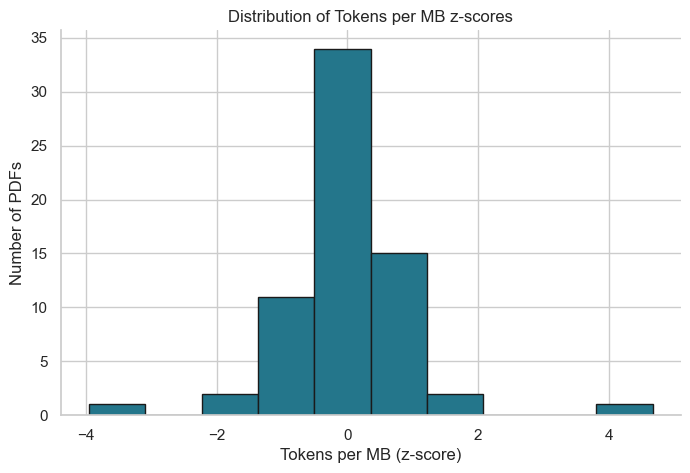

In [49]:
# Let's plot the distribution of tokens per MB z-scores to visualize the outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(
    df['tokens_per_mb_z'].dropna(),
    bins=10,
    color=sns.color_palette("crest", as_cmap=True)(0.6),
    edgecolor='k',
    alpha=1  # Make bars fully opaque
)
plt.xlabel('Tokens per MB (z-score)')
plt.ylabel('Number of PDFs')
plt.title('Distribution of Tokens per MB z-scores')
sns.despine()
#plt.grid(False)
plt.show()

The histogram of tokens per MB z-scores shows how each PDF’s token density compares to the average across the corpus. Most PDFs cluster around a z-score of 0, indicating their tokens-per-megabyte values are close to the mean, which suggests consistent OCR and text extraction quality for the majority of files. 

A few PDFs may fall into the tails of the distribution (z-scores below -1.5 or above 1.5), marking them as potential outliers. Low outliers could indicate missing or incomplete text extraction, while high outliers might suggest unusually dense text, duplicated content, or OCR artifacts. 

Overall, a roughly normal distribution centered near zero with few outliers implies that the extraction process was generally reliable, but the flagged outliers warrant further review to ensure data quality.

In [51]:
# Let's look at the z-score thresholds for outliers
# We can define thresholds for low and high outliers based on z-scores 
# and evaluate the potential outliers

thresholds = [1.5, 1.3, 1, -1, -1.3, -1.5]

for threshold in thresholds:
    if threshold > 0:
        outliers = df[df['tokens_per_mb_z'] > threshold]
        print(f"\nHigh outliers (z > {threshold}): {len(outliers)}")
    else:
        outliers = df[df['tokens_per_mb_z'] < threshold]
        print(f"\nLow outliers (z < {threshold}): {len(outliers)}")
    print(outliers[['pdf_filename', 'pdf_size_mb', 'output_tokens', 'tokens_per_mb', 'tokens_per_mb_z']])


High outliers (z > 1.5): 2
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb  \
9    163122_1-1964-06-B.pdf        37.59          44374    1180.473530   
11  163122_1-1964-09-01.pdf         3.25           5913    1819.384615   

    tokens_per_mb_z  
9          1.546297  
11         4.674061  

High outliers (z > 1.3): 3
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb  \
9    163122_1-1964-06-B.pdf        37.59          44374    1180.473530   
11  163122_1-1964-09-01.pdf         3.25           5913    1819.384615   
12     163122_1-1964-09.pdf        40.92          47752    1166.959922   

    tokens_per_mb_z  
9          1.546297  
11         4.674061  
12         1.480142  

High outliers (z > 1): 6
               pdf_filename  pdf_size_mb  output_tokens  tokens_per_mb  \
3      163122_1-1964-01.pdf        35.80          38662    1079.944134   
9    163122_1-1964-06-B.pdf        37.59          44374    1180.473530   
11  163122_1-1964-09-0

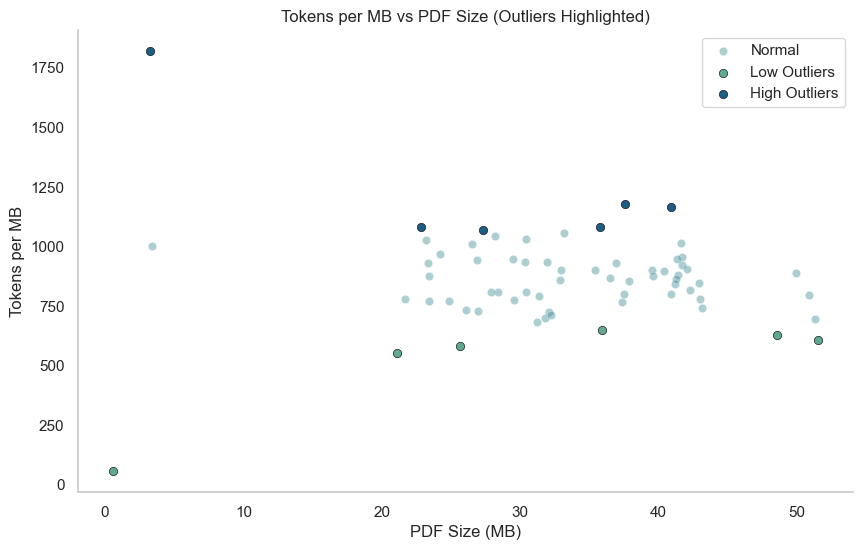

In [56]:
# Another way to visualize the outliers is a scatter plot

low_outliers = df[df['tokens_per_mb_z'] < -1]
high_outliers = df[df['tokens_per_mb_z'] > 1]

plt.figure(figsize=(10, 6))
palette = sns.color_palette("crest", 3)
sns.scatterplot(
    data=df, x='pdf_size_mb', y='tokens_per_mb',
    color=palette[1], alpha=0.4, label='Normal'
)
sns.scatterplot(
    data=low_outliers, x='pdf_size_mb', y='tokens_per_mb',
    color=palette[0], label='Low Outliers', edgecolor='k'
)
sns.scatterplot(
    data=high_outliers, x='pdf_size_mb', y='tokens_per_mb',
    color=palette[2], label='High Outliers', edgecolor='k'
)
plt.xlabel('PDF Size (MB)')
plt.ylabel('Tokens per MB')
plt.title('Tokens per MB vs PDF Size (Outliers Highlighted)')
sns.despine()
plt.legend()
plt.grid(False)
plt.show()

The code identifies outlier PDFs based on their tokens-per-MB z-scores, printing both high and low outliers for several thresholds. 

Let's look at an high outlier: '163122_1-1964-06-B.pdf'

From the pdf filename, we know that this is one of the PDFs that were split manually. Since it is a -B, it is the second part of the PDF. Upon closer investigation, we can see that this PDF is incredibly dense with text. It does not have the title page and the table of contents, which were left in the '163122_1-1964-06-A.pdf'. On top of that, the original 163122_1-1964-06.pdf was split into 3 parts, so the advertisements and subscription information usually at the end of each issue is in the 3rd part '163122_1-1964-06-C.pdf'. This means that '163122_1-1964-06-B.pdf' is just filled with double column text. This is the case for some other high outliers with z-scores larger than 1. They happen to be the middle parts of 3-way split PDFs.

Similarly, in the case of '163122_1-1964-09.pdf' the high z-score is because this is a longer issue with 76 pages (most issues are around 60 pages) but the PDF size is still small due to the scan quality and resolution. 

Let's look at a low outlier: '163122_2-1968-05-C.pdf'

This is the last part of a 3-way split PDF, meaning that the last few pages are devoted to advertisement, which our model is not transcribing. Also, there are more images in the issues from late 1967 and 1968 than in the previous years, including this one. But more importantly this part of the issue is filled with poetry, which takes up a lot more space due to its layout despite having fewer words than continious prose.

This analysis indeed revealed issue with three PDFs: '163122_2-1966-02-A.pdf', 163122_2-1966-09-B.pdf, and 163122_2-1967-09.pdf

All three are missing one or more articles entirely, with 163122_2-1966-09-B.pdf showing signs of degeneration and shuffling of the order of the articles. 163122_2-1967-09.pdf additionally has layout-related problems. This issue is the beginning of a new layout and more image-laden style for Parti Pris. Some of the short snippets between longer articles look like advertisements. There are several full-page images. 

All this shows that looking into outliers is a useful approach to identifying potential issues in a larger dataset. This might not reveal all the problems but being able to identify 3 PDFs with actual important OCR mistakes is rather useful.

## Table of Contents


One other way to check for completeness is looking at the table of contents for each issue. Luckily, the order of pages remained consistent across the entire print run. The ToC is always on the 3rd page of the PDF. We can automatically extract the 3rd page and extract ToC and metadata.

In [ ]:
# Let's extract the table of contents (ToC) from each PDF file

from pypdf import PdfReader, PdfWriter

input_folder = "your_path_here/pdfs"
output_folder = "your_path_here/toc_pdfs"

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(".pdf"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, f"toc_{filename}")

        reader = PdfReader(input_path)
        writer = PdfWriter()

        # Extract only page 3 (index 2)
        if len(reader.pages) >= 3:
            writer.add_page(reader.pages[2])

            with open(output_path, "wb") as out_file:
                writer.write(out_file)

We carefully studied the ToC and metadata to understand its structure and translate it into the JSON schema.

<div style="display: flex; gap: 20px;">
  <img src="../img/toc_early_issues.png" alt="ToC example from an earlier issue" width="45%">
  <img src="../img/toc_later_issues.png" alt="ToC example from a later issue" width="45%">
</div>

In [ ]:
# We use the same approach as the text extraction code to extract the ToC from each PDF file
# again this code won't run here, but you can use it as a template for your own corpus

class TOCMetadata(typing.TypedDict):
    issue_number: str                # e.g., "vol. 5 nos 2-3"
    season_or_month: str             # e.g., "été or oct.-nov."
    year: str                        # e.g., "1967"
    director: str                    # e.g., "philippe bernard"
    description: str                 # e.g., "revue politique et culturelle"
    price: str                       # e.g., "75¢", "$6.00"
    editors: list[str]               # e.g., ["philippe bernard", "gilles bourque", ...]
    collaborators: list[str]         # e.g., ["jacques allard", "denis arcand", ...]
    administration: list[str]        # e.g., ["gilles bourque", "gilles dostaler", ...]
    publisher: str                   # e.g., "La revue PARTI PRIS, inc."
    distributor: str                 # e.g., "agence de distribution populaire, 1130 Lagauchetière est, Montréal"

class TOCEntry(typing.TypedDict):
    section: str                     # e.g., "CHRONIQUES" or ""
    title: str                       # e.g., "le quèbec en mots dit"
    authors: list[str]               # e.g., ["gilles dostaler", "gaston miron", ...]
    page: str                        # e.g., "3"

class TOCExtraction(typing.TypedDict):
    metadata: TOCMetadata
    toc: list[TOCEntry]

pdf_folder = pathlib.Path('your_path_here/toc_pdfs')
output_folder = pathlib.Path('your_path_here/toc_transcriptions')
output_folder.mkdir(exist_ok=True)
csv_path = output_folder / 'transcription_usage.csv'

csv_fields = ['pdf_filename', 'json_filename', 'prompt_tokens', 'thoughts_tokens', 'output_tokens', 'total_tokens', 'note']

# Read already processed PDFs from CSV
processed_pdfs = set()
if csv_path.exists():
    with open(csv_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['json_filename']:  # Only consider as processed if JSON was created
                processed_pdfs.add(row['pdf_filename'])

prompt = """
You are an expert in French language journals. 
You will extract the metadata and the table of contents from a journal from the 1960s. 
Transcribe it as accurately as possible, keeping the original words.
If a field is missing, use an empty string or empty list.

Return ONLY the JSON object, with no extra text or explanation.
"""

for pdf_path in pdf_folder.glob('*.pdf'):
    if pdf_path.name in processed_pdfs:
        print(f"Already processed: {pdf_path.name}")
        continue

    filename = pdf_path.stem
    json_filename = filename + '.json'
    json_path = output_folder / json_filename

    try:
        file_upload = client.files.upload(file=pdf_path)
        response = client.models.generate_content(
            model=MODEL_ID,
            contents=[file_upload, prompt],
            config={
                'response_mime_type': 'application/json',
                'response_schema': TOCExtraction,
                'thinking_config': types.ThinkingConfig(thinking_budget=3000)
            },
        )

        if response.text is None:
            raise ValueError("API returned no text.")

        data = json.loads(response.text)
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

        info = {
            'pdf_filename': pdf_path.name,
            'json_filename': json_filename,
            'prompt_tokens': response.usage_metadata.prompt_token_count,
            'thoughts_tokens': response.usage_metadata.thoughts_token_count,
            'output_tokens': response.usage_metadata.candidates_token_count,
            'total_tokens': response.usage_metadata.total_token_count,
            'note': ''
        }

        write_header = not csv_path.exists()
        with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
            if write_header:
                writer.writeheader()
            writer.writerow(info)

        print(f"Processed: {json_filename}")
        print(f"Prompt tokens: {info['prompt_tokens']}")
        print(f"Thoughts tokens: {info['thoughts_tokens']}")
        print(f"Output tokens: {info['output_tokens']}")
        print(f"Total tokens: {info['total_tokens']}\n")

        time.sleep(30)

    except Exception as e:
        print(f"Error processing {pdf_path.name}: {e}")
        info = {
            'pdf_filename': pdf_path.name,
            'json_filename': '',
            'prompt_tokens': '',
            'thoughts_tokens': '',
            'output_tokens': '',
            'total_tokens': '',
            'note': f'ERROR: {e}'
        }
        write_header = not csv_path.exists()
        with open(csv_path, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_fields)
            if write_header:
                writer.writeheader()
            writer.writerow(info)
        continue

In [82]:
# The ToC transcriptions are saved in the data folder
# Let's load one and take a look at it

toc_example_path = '../data/toc_transcriptions/toc_163122_1-1963-10.json'
with open(toc_example_path, 'r', encoding='utf-8') as f:
    toc_example = json.load(f)

#print(toc_example)
articles_toc = toc_example['toc']
titles_toc = [article['title'] for article in articles_toc]
titles_toc

['présentation',
 'de la révolte à la révolution',
 'du duplessisme au F.L.Q.',
 'vers une révolution totale',
 "poème de l'antérévolution",
 'un enfant du pays',
 'blancheur de moi-même',
 "salutations d'usage",
 "chronique d'une révolution",
 'chronique du R.I.N.',
 'les divertissements',
 'paul morin',
 'pour riches seulement',
 "chronique de l'éducation",
 'vulgarités']

Neat! We can now compare the article titles and authors from the ToC and the full text extraction of the same issue

In [81]:
# Now with the full text file

with open("../data/transcriptions/163122_1-1963-10.json", "r", encoding="utf-8") as f:
    articles_fulltext = json.load(f)

titles_fulltext = [article["title"] for article in articles_fulltext]
titles_fulltext

['Présentation',
 'De la révolte à la révolution',
 'Du duplessisme au F.L.Q.',
 'Vers une révolution totale',
 "Poème de l'antérévolution",
 'Un enfant du pays',
 'Blancheur de moi-même',
 "Salutations d'usage",
 "Chronique d'une révolution",
 'Chronique du R.I.N.',
 'Les divertissements',
 'Paul Morin',
 'Pour riches seulement',
 "Chronique de l'éducation",
 'Vulgarités']

The first issue seems fine to me! We can scale this up to the entire corpus to see if and where have missing articles.

In [92]:
import re
from collections import defaultdict
from rapidfuzz import process, fuzz

FUZZY_THRESHOLD = 90  # You can adjust this value

def fuzzy_in_list(title, candidates, threshold=FUZZY_THRESHOLD):
    match, score, _ = process.extractOne(title, candidates, scorer=fuzz.token_sort_ratio)
    return score >= threshold

toc_dir = "../data/toc_transcriptions"
fulltext_dir = "../data/transcriptions"

# Helper: group fulltext files by base issue name (strip -A, -B, etc.)
def get_issue_base(filename):
    return re.sub(r"(-[A-Z])?\.json$", ".json", filename)

# Build a mapping from base issue name to all its split parts
fulltext_files = defaultdict(list)
for fname in os.listdir(fulltext_dir):
    if fname.endswith(".json"):
        base = get_issue_base(fname)
        fulltext_files[base].append(fname)

results = []

for toc_file in os.listdir(toc_dir):
    if not toc_file.endswith(".json"):
        continue
    toc_path = os.path.join(toc_dir, toc_file)
    # Remove 'toc_' prefix for matching
    base_issue = toc_file.replace("toc_", "")
    if base_issue not in fulltext_files:
        print(f"Missing fulltext for {toc_file}")
        continue

    # Load ToC titles
    with open(toc_path, "r", encoding="utf-8") as f:
        toc_data = json.load(f)
        toc_titles = [entry["title"].strip().lower() for entry in toc_data["toc"]]

    # Merge all split fulltext parts for this issue
    merged_articles = []
    for part_file in sorted(fulltext_files[base_issue]):
        with open(os.path.join(fulltext_dir, part_file), "r", encoding="utf-8") as f:
            merged_articles.extend(json.load(f))

    fulltext_titles = [entry["title"].strip().lower() for entry in merged_articles]

    # Compare
    missing_in_fulltext = [title for title in toc_titles if not fuzzy_in_list(title, fulltext_titles)]
    extra_in_fulltext = [title for title in fulltext_titles if not fuzzy_in_list(title, toc_titles)]

    results.append({
        "issue": toc_file,
        "missing_in_fulltext": missing_in_fulltext,
        "extra_in_fulltext": extra_in_fulltext
    })

# Print summary
for r in results:
    print(f"Issue: {r['issue']}")
    if r["missing_in_fulltext"]:
        print("  Missing in fulltext:", r["missing_in_fulltext"])
    if r["extra_in_fulltext"]:
        print("  Extra in fulltext:", r["extra_in_fulltext"])
    if not r["missing_in_fulltext"] and not r["extra_in_fulltext"]:
        print("  All titles match.")

Issue: toc_163122_2-1967-09.json
  Missing in fulltext: ['editorial', 'québec politique.', 'littérature québécoise.', 'temps modernes.', 'interprétation de la vie quotidienne.']
  Extra in fulltext: ['un nouveau parti pris', 'editorial: vive le québec libre!', 'i- des tentatives pour cerner notre alliénation', 'ii- de la contestation.', 'iii- la poussée indépendantiste.', 'iv- les revendications de 1960 à 1967', 'v- les groupes de pression', "vii- une volonté d'enracinement.", 'viii- internationalisation du québec', 'un carcan pour un autre', 'petit échantillonnage de lubricité', 'ceux qui pourrissent dans nos prisons depuis 1963.', 'notice necrologique pour notables et politiciens vereux.', 'québec politique. bougez pas, m. johnson!', 'littérature québécoise. david sterne: le pathétique de la misère ou la gloire de la finitude.', 'temps modernes. les moyens de communication', 'interprétation de la vie quotidienne. collage - “informations”', "qu'est-ce que le centrentenaire?"]
Issue: t

In [93]:
overview = []
for r in results:
    overview.append({
        "issue": r["issue"],
        "missing_count": len(r["missing_in_fulltext"]),
        "extra_count": len(r["extra_in_fulltext"]),
        "missing_titles": "; ".join(r["missing_in_fulltext"]),
        "extra_titles": "; ".join(r["extra_in_fulltext"]),
        "status": (
            "all_match"
            if not r["missing_in_fulltext"] and not r["extra_in_fulltext"]
            else "missing" if r["missing_in_fulltext"] and not r["extra_in_fulltext"]
            else "extra" if r["extra_in_fulltext"] and not r["missing_in_fulltext"]
            else "both"
        ),
    })

df_overview = pd.DataFrame(overview)
df_overview.head()

,issue,missing_count,extra_count,missing_titles,extra_titles,status
0,toc_163122_2-1967-09.json,5,18,editorial; québec politique.; littérature québ...,un nouveau parti pris; editorial: vive le québ...,both
1,toc_163122_2-1966-04.json,4,9,entretien avec claude gauvreau; entretien avec...,"""papa boss"", de jacques ferron; de l'amour fou...",both
2,toc_163122_1-1964-01.json,8,12,gilles vigneault; nina bruneau; luc racine; mi...,l'acheteur; variations sur un vieux thème; mad...,both
3,toc_163122_2-1967-05.json,15,24,éditorial; présentation; production culturelle...,éditorial que faire?; présentation dépossessio...,both
4,toc_163122_1-1963-12.json,2,2,"ce bordel de pays, 1-; chronique de l'éducation","ce bordel de pays, 1- import - export; l'unive...",both
